## RT Plan and dose calculation
#### author: Schyns Romain

# NOT FINISHED YET

In [1]:
import os
import matplotlib.pyplot as plt
from opentps.core.data.plan._rtPlan import RTPlan
from opentps.core.io.scannerReader import readScanner
from opentps.core.io.serializedObjectIO import loadRTPlan, saveRTPlan
from opentps.core.io.dicomIO import readDicomPlan
from opentps.core.io.dataLoader import readData
from opentps.core.data.CTCalibrations.MCsquareCalibration._mcsquareCTCalibration import MCsquareCTCalibration
from opentps.core.io import mcsquareIO
from opentps.core.data._dvh import DVH
from opentps.core.processing.doseCalculation.doseCalculationConfig import DoseCalculationConfig
from opentps.core.processing.doseCalculation.mcsquareDoseCalculator import MCsquareDoseCalculator
from opentps.core.io.mhdIO import exportImageMHD, importImageMHD
from opentps.core.data.plan._planIonBeam import PlanIonBeam
from opentps.core.data.plan._planIonLayer import PlanIonLayer
from opentps.core.data.images._ctImage import CTImage
from opentps.core.data._rtStruct import RTStruct

08/08/2023 02:14:17 PM - root - INFO - Loading logging configuration: /home/romain/opentps/opentps_core/opentps/core/config/logger/logging_config.json
08/08/2023 02:14:17 PM - opentps.core._loggingConfig - INFO - Log level set: INFO
08/08/2023 02:14:17 PM - opentps.core.processing.imageProcessing.cupyImageProcessing - WARNING - Cannot import Cupy module
08/08/2023 02:14:17 PM - opentps.core.processing.registration.registrationMorphons - WARNING - cupy not found.
08/08/2023 02:14:17 PM - opentps.core.processing.C_libraries.libInterp3_wrapper - WARNING - cupy not found.


### Create plan from scratch

In [2]:
plan = RTPlan()
plan.appendBeam(PlanIonBeam())
plan.appendBeam(PlanIonBeam())
plan.beams[1].gantryAngle = 120.
plan.beams[0].appendLayer(PlanIonLayer(100))
plan.beams[0].appendLayer(PlanIonLayer(90))
plan.beams[1].appendLayer(PlanIonLayer(80))
plan[0].layers[0].appendSpot([-1,0,1], [1,2,3], [0.1,0.2,0.3])
plan[0].layers[1].appendSpot([0,1], [2,3], [0.2,0.3])
plan[1].layers[0].appendSpot(1, 1, 0.5)
# Save plan
saveRTPlan(plan,'test_plan.tps')

Load plan in OpenTPS format (serialized)

In [3]:
plan2 = loadRTPlan('test_plan.tps')
print(plan2[0].layers[1].spotWeights)
print(plan[0].layers[1].spotWeights)
plan_path = r"/home/romain/dataset_testing/ANON104_HAN_ORO/RP1.2.752.243.1.1.20201215163404059.2000.47734.dcm"
plan3 = readDicomPlan(plan_path)

print(plan3.beams[0].rangeShifter)

[0.2 0.3]
[0.2 0.3]
RS_ID = RS40
RS_type = binary
RS_density = 1.0
RS_WET = 40.0


### Dose computation from plan

choosing default scanner and BDL

In [4]:
doseCalculator = MCsquareDoseCalculator()
doseCalculator.ctCalibration = readScanner(DoseCalculationConfig().scannerFolder)
doseCalculator.beamModel = mcsquareIO.readBDL(DoseCalculationConfig().bdlFile)
doseCalculator.nbPrimaries = 1e7
ctImagePath = r'/home/romain/dataset_testing/ANON104_HAN_ORO'
dataList = readData(ctImagePath, maxDepth=0)
ct = [d for d in dataList if isinstance(d, CTImage)][0]
struct = [d for d in dataList if isinstance(d, RTStruct)][0]

/home/romain/dataset_testing/ANON104_HAN_ORO/CT1.2.826.0.1.3680043.2.135.736991.38856790.7.1596614875.808.5.dcm
/home/romain/dataset_testing
/home/romain/dataset_testing/ANON104_HAN_ORO/CT1.2.826.0.1.3680043.2.135.736991.38856790.7.1596614876.104.25.dcm
/home/romain/dataset_testing
/home/romain/dataset_testing/ANON104_HAN_ORO/CT1.2.826.0.1.3680043.2.135.736991.38856790.7.1596614876.104.26.dcm
/home/romain/dataset_testing
/home/romain/dataset_testing/ANON104_HAN_ORO/CT1.2.826.0.1.3680043.2.135.736991.38856790.7.1596614876.11.14.dcm
/home/romain/dataset_testing
/home/romain/dataset_testing/ANON104_HAN_ORO/CT1.2.826.0.1.3680043.2.135.736991.38856790.7.1596614876.11.15.dcm
/home/romain/dataset_testing
/home/romain/dataset_testing/ANON104_HAN_ORO/CT1.2.826.0.1.3680043.2.135.736991.38856790.7.1596614876.120.27.dcm
/home/romain/dataset_testing
/home/romain/dataset_testing/ANON104_HAN_ORO/CT1.2.826.0.1.3680043.2.135.736991.38856790.7.1596614876.136.28.dcm
/home/romain/dataset_testing
/home/rom

If we want to crop the CT to the body contour (set everything else to -1024)

In [5]:
contour_name = 'BODY'
struct.print_ROINames()
body_contour = struct.getContourByName(contour_name)
doseCalculator.overwriteOutsideROI = body_contour


RT Struct UID: 1.2.752.243.1.1.20201207111129661.2000.42135.1
  [0]  BODY
  [1]  SpinalCord
  [2]  Brainstem
  [3]  Parotid_R
  [4]  Parotid_L
  [5]  Mandible
  [6]  GTV_N
  [7]  CTVrn_70Gy
  [8]  CTVln_54.25Gy
  [9]  CTVrn_54.25Gy
  [10]  GTVt
  [11]  CTVt_70Gy
  [12]  CTVt_54.25Gy
  [13]  ConstrictorM
  [14]  Esophagus
  [15]  Trachea
  [16]  Larynx
  [17]  PRV_BS
  [18]  PRV_SC
  [19]  PTVnl_54.25Gy
  [20]  PTVnr_54.25Gy
  [21]  PTVnr_70Gy
  [22]  PTVt_54.25Gy
  [23]  PTVt_70Gy
  [24]  tomo in 54.25
  [25]  tomo out 54.25
  [26]  tomo out 70
  [27]  tomo in 70
  [28]  skin L
  [29]  skin R
  [30]  CTVn_5425
  [31]  CTVn_7000
  [32]  CTVp_7000
  [33]  SupraglotLarynx
  [34]  GlotticArea
  [35]  Esophagus_upper
  [36]  PharConsInf
  [37]  PharConsMid
  [38]  PharConsSup
  [39]  Submandibular_L
  [40]  Submandibular_R
  [41]  OralCavity
  [42]  BoxDown
  [43]  BoxLeft
  [44]  CTV_7000
  [45]  CTV_all
  [46]  CTVnR_5425
  [47]  CTVnL_5425
  [48]  CTVnR_7000
  [49]  CTVnL_5425_Up
  [50]

MC square simulation and Dose exportation

In [6]:
doseImage = doseCalculator.computeDose(ct, plan)
exportImageMHD(r'/home/romain/doseCal', doseImage)
#doseImage = importImageMHD(r'/home/romain/doseCal.mhd')

08/08/2023 02:14:27 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Prepare MCsquare Dose calculation
08/08/2023 02:14:27 PM - opentps.core.io.mcsquareIO - INFO - Cropping CT around BODY
08/08/2023 02:14:28 PM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/romain/openTPS_workspace/Simulations/MCsquare_simulation/CT.mhd
08/08/2023 02:14:29 PM - opentps.core.io.mcsquareIO - INFO - Write plan: /home/romain/openTPS_workspace/Simulations/MCsquare_simulation/PlanPencil.txt
08/08/2023 02:14:29 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Start MCsquare simulation


MCsquare: 7: [: Linux: unexpected operator





Initialization time: 0.735741 s 


Simulation started (2023-08-08 14:14:30) 
 10.0 % 
 20.0 % 
 30.0 % 
 40.0 % 
 50.0 % (stat uncertainty: 0.61 %) 
 60.0 % (stat uncertainty: 0.57 %) 
 70.0 % (stat uncertainty: 0.54 %) 
 80.0 % (stat uncertainty: 0.51 %) 
 90.0 % (stat uncertainty: 0.49 %) 
 100.0 % (stat uncertainty: 0.47 %) 

Nbr primaries simulated: 10000000 
MC computation time: 77.978948 s 
Output computation time: 0.135290 s 

Total computation time: 78.875868 s 
08/08/2023 02:15:49 PM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/romain/doseCal.mhd


DVH

(512, 512, 135)
D95 0
D5 0
Dmax 0.17457364
Dmin 0.0


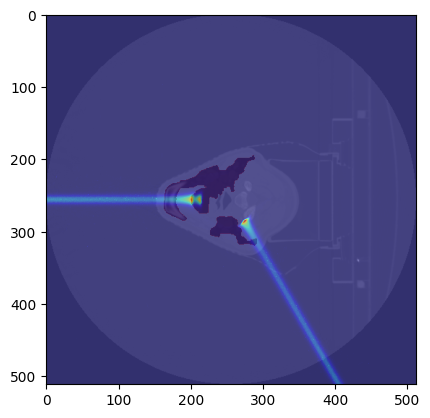

In [7]:
target_names = 'OralCavity Mandible CTVt_54.25Gy CTV_all' # 
print(ct.imageArray.shape)
target_contour = struct.make1ContourFromSeveral(target_names,ct)
#arget_contour = struct.getContourByName(target_name)
print(target_contour)
dvh = DVH(target_contour, doseImage)
print("D95",dvh._D95)
print("D5",dvh._D5)
print("Dmax",dvh._Dmax)
print("Dmin",dvh._Dmin)
sliceLoc = 65
plt.imshow(ct.imageArray[:,:,sliceLoc],cmap='gray')
plt.imshow(target_contour.getBinaryMask(origin= ct.origin,gridSize= ct.gridSize,spacing=ct.spacing).imageArray[:,:,sliceLoc],alpha =.4,cmap='Reds')
plt.imshow(doseImage.imageArray[:,:,sliceLoc],alpha=0.5,cmap='jet' )